In [2]:
import torch
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [3]:
X, y = make_moons(n_samples=50, noise=0.1)
X

array([[-0.1246437 ,  1.07303822],
       [-0.95546776,  0.19913728],
       [ 0.92763108, -0.12940823],
       [-0.90296233,  0.23607486],
       [ 1.00998603,  0.08282253],
       [ 0.57354878, -0.36395305],
       [-0.34064121,  0.79365912],
       [ 0.34867624, -0.17366711],
       [ 1.89829283,  0.38366755],
       [ 0.59532184,  0.94006773],
       [ 0.17786431, -0.0836003 ],
       [-0.94120356,  0.39131048],
       [ 1.73930747,  0.40894497],
       [ 0.45292304, -0.28200724],
       [ 1.28829896, -0.44974394],
       [ 2.0186539 , -0.07970137],
       [-0.1643172 ,  0.36450458],
       [-0.47570631,  0.87789233],
       [ 0.21318421,  0.89172431],
       [ 1.92682484,  0.57758771],
       [ 0.00570585,  0.03664386],
       [ 1.06473197, -0.48644061],
       [ 0.8057213 ,  0.06045025],
       [ 1.43955105, -0.32138275],
       [ 0.69874021, -0.34544442],
       [ 1.4724645 , -0.40529736],
       [-0.09997241,  0.43766206],
       [-0.70724671,  0.68623376],
       [ 0.34172615,

In [4]:
# Moons
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y).float()

# pick some points to delete
X_del = []
y_del = []

for i in range(50):
    if y[i] == 1 and X[i, 0] < 0 and X[i, 1] > 0:
        X_del.append([X[i,0],X[i,1]])
        y_del.append(y[i])


y = y.view(-1)
y_del = torch.tensor(y_del).view(-1)
X_del = torch.tensor(X_del)
X_del = X_del.float()
y_del = y_del.float()

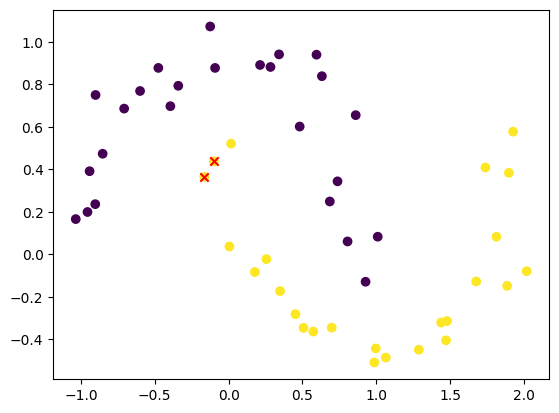

In [5]:
# plot the data points above

plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(X_del[:,0], X_del[:,1], marker='x', c='r')
plt.show()

In [6]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class MyFirstBNN(PyroModule):
    def __init__(self, in_dim=2, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        # x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        logits = self.layer2(x).squeeze(-1)
        prob = torch.sigmoid(logits)

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)
        return prob

In [7]:
X.shape, y.shape

(torch.Size([50, 2]), torch.Size([50]))

In [8]:
from pyro.infer import MCMC, NUTS

model = MyFirstBNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

# Convert data to PyTorch tensors
# x_train = torch.from_numpy(X).float()
# y_train = torch.from_numpy(y).float()

# Run MCMC
mcmc.run(X, y)

Warmup:   0%|          | 0/100 [00:00, ?it/s]

Sample: 100%|██████████| 100/100 [00:22,  4.42it/s, step size=1.15e-02, acc. prob=0.864]


In [9]:
# get mean and cov matrix of mcmc samples and use them to make normal distribution over model parameters and then predict

# mcmc_samples = {k: [v.mean(0), torch.cov(torch.stack(list(v.flatten(1))))] for k, v in mcmc.get_samples().items()}
# mcmc_samples = {k: [v.mean(0), torch.cov(torch.stack(list(v.flatten(1))).T), v.shape] for k, v in mcmc.get_samples().items()}

params_list = []

for k, v in mcmc.get_samples().items():
    params_list.append(v.flatten(1))

params_list

# torch.stack([mcmc.get_samples()['layer1.weight'].flatten(1)[0], mcmc.get_samples()['layer1.weight'].flatten(1)[1]])

[tensor([[  5.2820,  -1.4310,  -5.7380, -12.7120,  -2.3463],
         [  5.7189,  -5.1456,  -9.7041,  -8.0170,  -5.9600],
         [  9.3422,  -4.5837,  -9.9318,  -7.1298,  -0.1520],
         [ 11.9553,  -6.4744,  -0.5557, -13.7481,  -4.2955],
         [ 12.1097,  -6.2805,  14.7511, -11.2525, -16.1602],
         [  8.1035,  -7.4357,  10.5804, -10.7882, -20.6288],
         [  4.7481,  -7.4057,   6.6858, -12.4656, -17.4820],
         [ 15.3307,  -0.6672, -22.3701,  -6.0651, -12.5450],
         [  6.3358,  -4.3955, -12.4723, -12.2288, -16.6381],
         [  6.0799,  -6.0399,  -0.5864,  -5.9080, -24.2934],
         [  5.0507,  -6.8178,   2.7537, -10.2183, -25.5442],
         [ 13.2687,  -5.2241,  -7.8722, -15.1569,   3.2420],
         [ 13.0677,  -4.2543,  -4.0304, -14.4634,   2.9720],
         [ 11.4967,  -2.8489, -11.3233,  -8.1307,  13.5716],
         [  8.5395,  -4.2636, -11.3436, -10.5949,  12.0399],
         [ 11.0942,  -2.9110, -10.0197, -12.4239,  13.9472],
         [  6.9073,  -3.

In [10]:
from pyro.infer import Predictive
import numpy as np

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x1_test = torch.linspace(-1, 2, 1000)
x2_test = torch.linspace(-1, 1.5, 1000)
x_test = np.array(np.meshgrid(x1_test, x2_test)).T.reshape(-1, 2)
x_test = torch.tensor(x_test).float()
preds = predictive(x_test)

In [19]:
x_test.shape, x_test

(torch.Size([1000000, 2]),
 tensor([[-1.0000, -1.0000],
         [-1.0000, -0.9975],
         [-1.0000, -0.9950],
         ...,
         [ 2.0000,  1.4950],
         [ 2.0000,  1.4975],
         [ 2.0000,  1.5000]]))

In [40]:
preds, preds["obs"].shape

({'obs': tensor([[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 0., 0., 0.]])},
 torch.Size([50, 1000000]))

In [41]:
preds_mean = preds["obs"].mean(0)
preds_mean, preds_mean.shape

(tensor([0.6800, 0.6800, 0.6800,  ..., 0.4200, 0.4200, 0.4400]),
 torch.Size([1000000]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


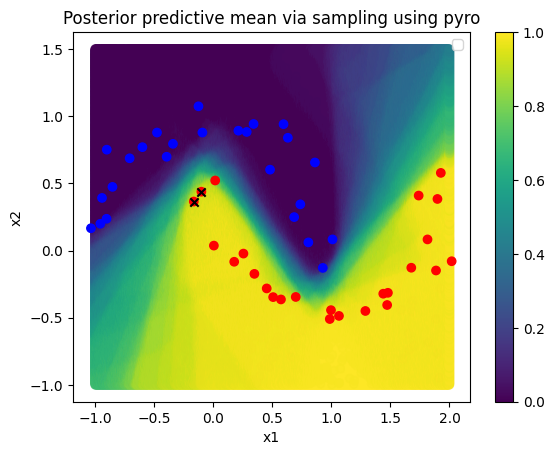

In [39]:
# plot the data points above for each grid point
plt.scatter(x_test[:,0], x_test[:,1], c=preds_mean, alpha=0.2)
# plt.contourf(x1_test, x2_test, preds_mean.reshape(1000,1000), cmap='bwr', alpha=0.5)
# plt.contourf(x_test, x_test, preds_mean, cmap='bwr', alpha=0.5)
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
plt.scatter(X_del[:,0], X_del[:,1], marker='x', c='black')
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.legend()
plt.title("Posterior predictive mean via sampling using pyro")
plt.show()

/var/folders/nf/tcn1v_gx4pvc23db1_jd0_zr0000gq/T/ipykernel_90586/3919130766.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  contour = plt.contourf(x1_test, x2_test, preds_mean_np.T, cmap='bwr', alpha=0.5, label='posterior predictive mean')


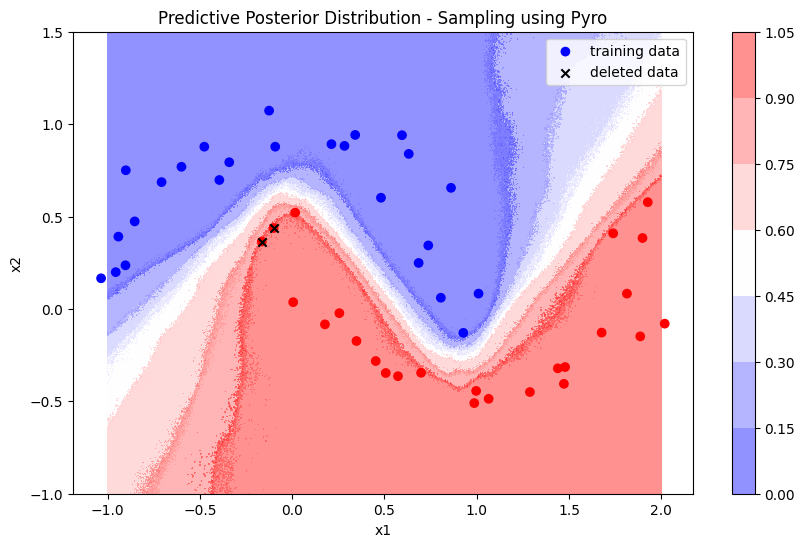

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming you have your x_test and preds_mean
# x_test = ...

# Convert torch tensor to NumPy array
preds_mean_np = preds_mean.cpu().numpy() if torch.is_tensor(preds_mean) else preds_mean

# Reshape the predictions to match the shape of x1_test and x2_test
preds_mean_np = preds_mean_np.reshape(len(x1_test), len(x2_test))

# Create a contour plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(x1_test, x2_test, preds_mean_np.T, cmap='bwr', alpha=0.5, label='posterior predictive mean')
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', label='training data')
plt.scatter(X_del[:,0], X_del[:,1], marker='x', c='black', label='deleted data')
plt.colorbar(contour)
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Predictive Posterior Distribution - Sampling using Pyro")
plt.show()


# Circles

In [52]:
# Circles
X, y = make_circles(n_samples=100, noise=0.02, random_state=42)
X = torch.tensor(X).float()
y = torch.tensor(y).float()

# # pick some points to delete
X_del = []
y_del = []

for i in range(100):
    if y[i] == 1 and X[i, 0] > 0.5:
        X_del.append([X[i,0],X[i,1]])
        y_del.append(y[i])


y = y.view(-1)
y_del = torch.tensor(y_del).view(-1)
X_del = torch.tensor(X_del)
X_del = X_del.float()
y_del = y_del.float()

In [56]:
from pyro.infer import MCMC, NUTS

model_circles = MyFirstBNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel_circles = NUTS(model_circles, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc_circles = MCMC(nuts_kernel_circles, num_samples=50)

# Convert data to PyTorch tensors
# x_train = torch.from_numpy(X).float()
# y_train = torch.from_numpy(y).float()

# Run MCMC
mcmc_circles.run(X, y)

Sample: 100%|██████████| 100/100 [00:31,  3.14it/s, step size=9.13e-03, acc. prob=0.977]


In [59]:
from pyro.infer import Predictive
import numpy as np

predictive_circles = Predictive(model=model_circles, posterior_samples=mcmc_circles.get_samples())
x1_test = torch.linspace(-2, 2, 1000)
x2_test = torch.linspace(-2, 2, 1000)
x_test = np.array(np.meshgrid(x1_test, x2_test)).T.reshape(-1, 2)
x_test = torch.tensor(x_test).float()
preds_circles = predictive_circles(x_test)
preds_circles_mean = preds_circles["obs"].mean(0)
preds_circles_mean, preds_circles_mean.shape

(tensor([0.0400, 0.0400, 0.0400,  ..., 0.1400, 0.1000, 0.1600]),
 torch.Size([1000000]))

/var/folders/nf/tcn1v_gx4pvc23db1_jd0_zr0000gq/T/ipykernel_90586/2827881457.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  contour = plt.contourf(x1_test, x2_test, preds_circles_mean_np.T, cmap='bwr', alpha=0.5, label='posterior predictive mean')


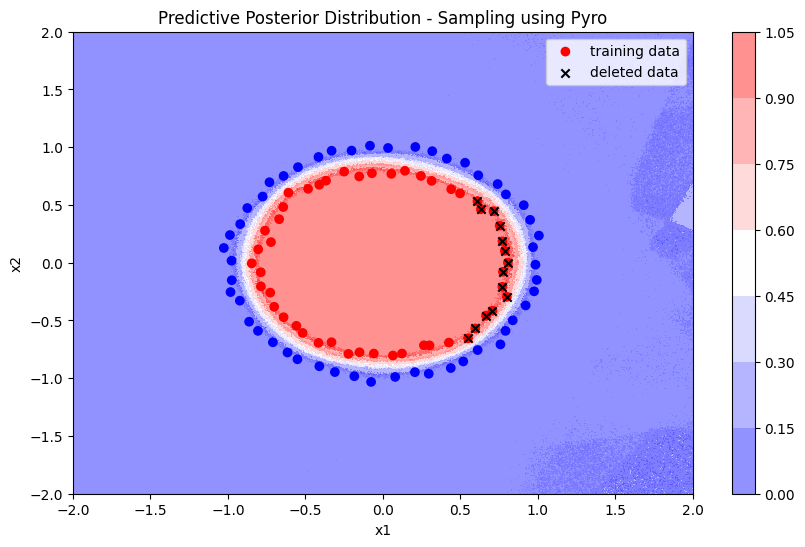

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming you have your x_test and preds_circles_mean
# x_test = ...

# Convert torch tensor to NumPy array
preds_circles_mean_np = preds_circles_mean.cpu().numpy() if torch.is_tensor(preds_circles_mean) else preds_circles_mean

# Reshape the predictions to match the shape of x1_test and x2_test
preds_circles_mean_np = preds_circles_mean_np.reshape(len(x1_test), len(x2_test))

# Create a contour plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(x1_test, x2_test, preds_circles_mean_np.T, cmap='bwr', alpha=0.5, label='posterior predictive mean')
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', label='training data')
plt.scatter(X_del[:,0], X_del[:,1], marker='x', c='black', label='deleted data')
plt.colorbar(contour)
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Predictive Posterior Distribution - Sampling using Pyro")
plt.show()


# Swiss

In [61]:
# Swiss Roll
X, y = make_blobs(n_samples=50, centers=2, n_features=2, random_state=42)
X = torch.tensor(X).float()
y = torch.tensor(y).float()
X = torch.cat((X, torch.tensor([[0, 5]]).float()))
y = torch.cat((y, torch.tensor([1]).float()))
X = torch.cat((X, torch.tensor([[-1, 5]]).float()))
y = torch.cat((y, torch.tensor([1]).float()))

X_del = torch.tensor([[0, 5]]).float()
y_del = torch.tensor([1]).float()
X_del = torch.cat((X_del, torch.tensor([[-1, 5]]).float()))
y_del = torch.cat((y_del, torch.tensor([1]).float()))

In [62]:
from pyro.infer import MCMC, NUTS

model_swiss = MyFirstBNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel_swiss = NUTS(model_swiss, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc_swiss = MCMC(nuts_kernel_swiss, num_samples=50)

# Convert data to PyTorch tensors
# x_train = torch.from_numpy(X).float()
# y_train = torch.from_numpy(y).float()

# Run MCMC
mcmc_swiss.run(X, y)

Warmup:   0%|          | 0/100 [00:00, ?it/s]

Sample: 100%|██████████| 100/100 [00:26,  3.84it/s, step size=4.22e-02, acc. prob=0.441]


In [69]:
from pyro.infer import Predictive
import numpy as np

predictive_swiss = Predictive(model=model_swiss, posterior_samples=mcmc_swiss.get_samples())
x1_test = torch.linspace(-6, 10, 1000)
x2_test = torch.linspace(-2, 12, 1000)
x_test = np.array(np.meshgrid(x1_test, x2_test)).T.reshape(-1, 2)
x_test = torch.tensor(x_test).float()
preds_swiss = predictive_swiss(x_test)
preds_swiss_mean = preds_swiss["obs"].mean(0)
preds_swiss_mean, preds_swiss_mean.shape

(tensor([0.0600, 0.0400, 0.0400,  ..., 0.8800, 0.8400, 0.9200]),
 torch.Size([1000000]))

/var/folders/nf/tcn1v_gx4pvc23db1_jd0_zr0000gq/T/ipykernel_90586/3684182069.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  contour = plt.contourf(x1_test, x2_test, preds_swiss_mean_np.T, cmap='bwr', alpha=0.5, label='posterior predictive mean')


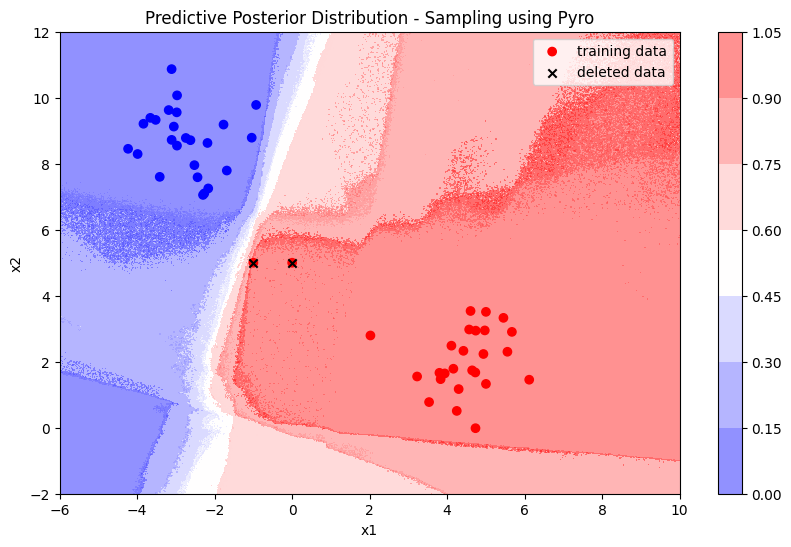

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming you have your x_test and preds_swiss_mean
# x_test = ...

# Convert torch tensor to NumPy array
preds_swiss_mean_np = preds_swiss_mean.cpu().numpy() if torch.is_tensor(preds_swiss_mean) else preds_swiss_mean

# Reshape the predictions to match the shape of x1_test and x2_test
preds_swiss_mean_np = preds_swiss_mean_np.reshape(len(x1_test), len(x2_test))

# Create a contour plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(x1_test, x2_test, preds_swiss_mean_np.T, cmap='bwr', alpha=0.5, label='posterior predictive mean')
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', label='training data')
plt.scatter(X_del[:,0], X_del[:,1], marker='x', c='black', label='deleted data')
plt.colorbar(contour)
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Predictive Posterior Distribution - Sampling using Pyro")
plt.show()
